In [28]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32

train = tf.keras.preprocessing.image_dataset_from_directory(
    "Train",
    seed=123,
    shuffle=True,
    image_size = (256,256),
    batch_size=BATCH_SIZE
)

Found 39209 files belonging to 43 classes.


In [3]:
classes = train.class_names
classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '5',
 '6',
 '7',
 '8',
 '9']

In [4]:
class_names = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Vehicle > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing vehicle > 3.5 tons' }

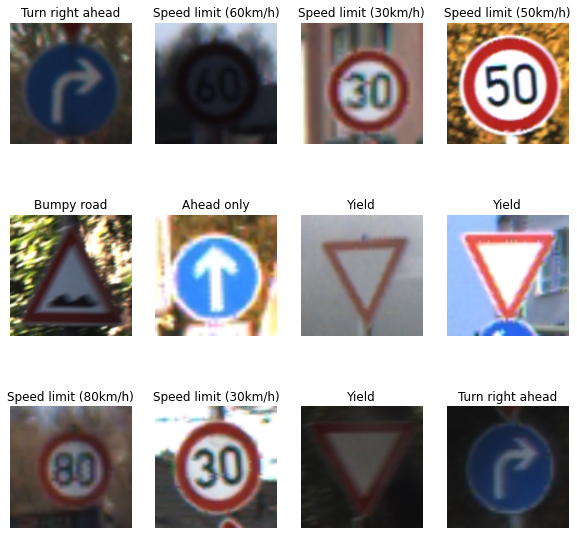

In [6]:
def plot_images(dataset):
    plt.figure(figsize=(10, 10))
    for image_batch, labels_batch in dataset.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[int(classes[labels_batch.numpy()[i]])])
            plt.axis("off")
            
plot_images(train)

In [7]:
train_split = 0.8
train_size = int(len(train)*train_split)

train_ds = train.take(train_size)
val_ds = train.skip(train_size)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
input_shape = (BATCH_SIZE, 256, 256, 3)
n_classes = 43

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (5,5), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((3, 3)),
    layers.Dropout(rate=0.25),
    layers.Conv2D(64,  kernel_size = (5,5), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Dropout(rate=0.25),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(rate=0.25),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(rate=0.25),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(rate=0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.25),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 252, 252, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 84, 84, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 84, 84, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (32, 80, 80, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 26, 26, 64)         0         
 2D)                                                  

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights = True)

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100
980/980 [==============================] - 267s 184ms/step - loss: 1.7002 - accuracy: 0.4941 - val_loss: 0.6048 - val_accuracy: 0.8553
Epoch 2/100
980/980 [==============================] - 147s 150ms/step - loss: 0.4253 - accuracy: 0.8620 - val_loss: 0.1737 - val_accuracy: 0.9552
Epoch 3/100
980/980 [==============================] - 141s 144ms/step - loss: 0.2108 - accuracy: 0.9334 - val_loss: 0.0922 - val_accuracy: 0.9787
Epoch 4/100
980/980 [==============================] - 140s 143ms/step - loss: 0.1447 - accuracy: 0.9528 - val_loss: 0.0517 - val_accuracy: 0.9874
Epoch 5/100
980/980 [==============================] - 138s 141ms/step - loss: 0.1161 - accuracy: 0.9636 - val_loss: 0.0475 - val_accuracy: 0.9899
Epoch 6/100
980/980 [==============================] - 140s 143ms/step - loss: 0.0981 - accuracy: 0.9689 - val_loss: 0.0465 - val_accuracy: 0.9885
Epoch 7/100
980/980 [==============================] - 140s 143ms/step - loss: 0.0824 - accuracy: 0.9752 - val_loss: 0

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

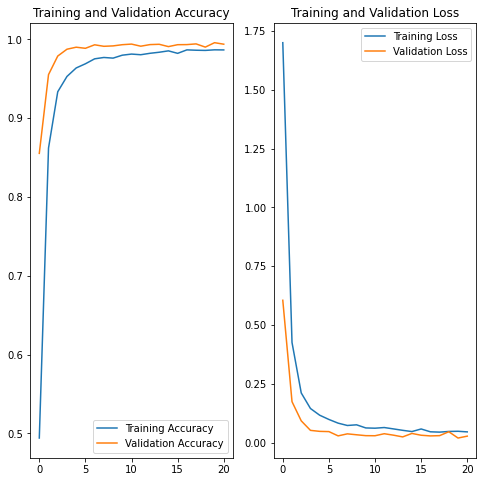

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(21), acc, label='Training Accuracy')
plt.plot(range(21), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(21), loss, label='Training Loss')
plt.plot(range(21), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
import pandas as pd
from PIL import Image
import numpy as np
def testing(testcsv):
    y_test = pd.read_csv(testcsv)
    label = y_test["ClassId"].values
    imgs = y_test["Path"].values
    data=[]
    for img in imgs:
        image = Image.open(img)
        image = image.resize((256,256))
        data.append(np.array(image))
    X_test=np.array(data)
    return X_test,label

In [19]:
X_test, label = testing('Test.csv')

In [20]:
label

array([16,  1, 38, ...,  6,  7, 10])

In [21]:
label2 = label.copy()

In [22]:
mapping = {}
mapping[int(classes[0])]=0
for i in range(len(classes)):
   mapping[int(classes[i])]=i


In [23]:
for i in range(len(label)):
    label2[i] = mapping[label[i]]
    
label2

array([ 8,  1, 32, ..., 39, 40,  2])

In [24]:
test_tf = tf.data.Dataset.from_tensor_slices((X_test, label2))
test_tf = test_tf.batch(BATCH_SIZE)

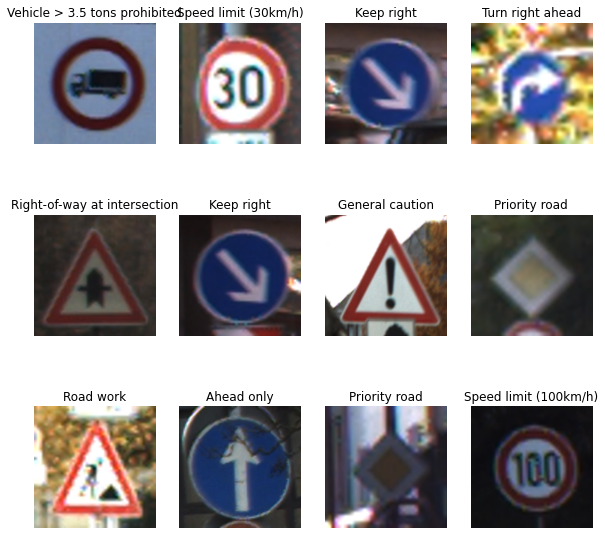

In [25]:
plot_images(test_tf)

In [26]:
model.evaluate(test_tf)

395/395 [==============================] - 16s 39ms/step - loss: 0.2236 - accuracy: 0.9609


[0.22360248863697052, 0.9608867764472961]

In [41]:
def predict(model, images):
    img_array = tf.keras.preprocessing.image.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
   
    predictions = model.predict(img_array)

    predicted_class = class_names[int(classes[np.argmax(predictions[0])])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


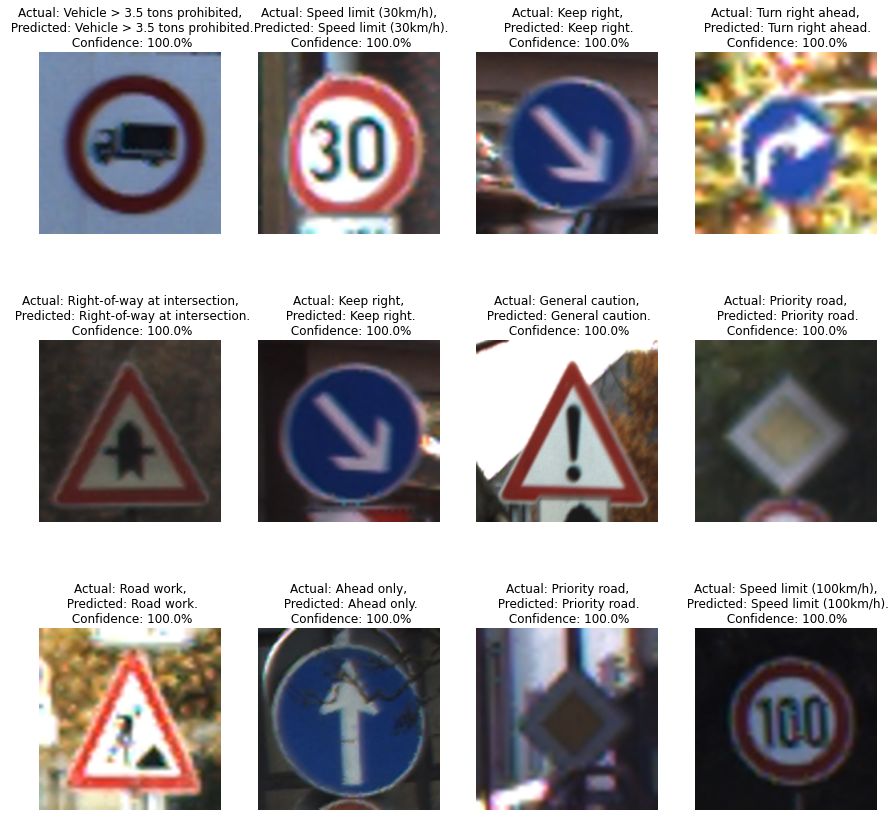

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_tf.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[int(classes[labels.numpy()[i]])]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")